# Experimento 1
***
- Conjuntos de dados: Montgomery + Shenzen
- Testando a equalização de histograma em comparação com a mudança típica de escala

### Importando os pacotes necessários

In [1]:
import glob
import re
from tqdm import tqdm
import urllib.request
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import cv2
import torch
import albumentations as A
from lungs_segmentation.pre_trained_models import create_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from lungs_segmentation.pre_trained_models import create_model
import lungs_segmentation.inference as inference
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import os

model_seg = create_model("resnet34", )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_seg = model_seg.to(device)


def segmentation(image = [], path = 'image.png'):

  try:
    image = tf.keras.preprocessing.image.array_to_img(image)
    tf.keras.preprocessing.image.save_img(path, image)
  except:
    pass
    
  image, mask = inference.inference(model_seg, path, 0.2)
  for values_i in range(0, len(mask[0])):
    for values_j in range(0, len(mask[0])):
      if (mask[0, values_i, values_j] + mask[1, values_i, values_j]) == 0:
        image[values_i, values_j, 0] = 0
        image[values_i, values_j, 1] = 0
        image[values_i, values_j, 2] = 0
  
  return image

### Pré-processando os dados

In [3]:
# coletando o caminho dos arquivos dos dados do hospital shenzen
filelist_shenzen = glob.glob('/content/drive/MyDrive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/*.png')
# coletando o caminho dos arquivos dos dados do hospital montgomery
filelist_montgomery = glob.glob('/content/drive/MyDrive/Montgomery/MontgomerySet/CXR_png/*.png')
# juntando os dois datasets
filelist = filelist_shenzen + filelist_montgomery

In [4]:
# quantidade de imagens disponíveis no dataset
print('quantidade de imagens:', str(len(filelist)))

quantidade de imagens: 800


In [5]:
def extract_label(file_list):
    
    # inicializando uma lista vazia
    labels = []
    
    # iterando na lista de arquivos
    for file in tqdm(file_list):
        # detectando as classes presentes no nome da imagem
        current_label = re.findall('[0-9]{4}_(.+?).png', file)
        # adicionando a lista de rótulos as classes correspondentes a cada uma das imagens
        labels.append(current_label[0])
        
    return labels

In [6]:
# extraindo os rótulos
labels = extract_label(filelist)

100%|██████████| 800/800 [00:00<00:00, 155878.62it/s]


In [7]:
# visualizando a quantidade de rótulos
print('quantidade de rótulos:', str(len(labels)))

quantidade de rótulos: 800


In [8]:
# criando um dataframe com os caminhos das imagens
full_data = pd.DataFrame(filelist, columns = ['filepath'])
# adicionando os rótulos em cada imagem
full_data['target'] = labels

In [9]:
# modificando o formato dos dados para float32
dict_type = {'target': 'float32'}
full_data = full_data.astype(dict_type)

In [10]:
# separando os dados de treinamento e de teste
train_df, test_df = train_test_split(full_data, stratify = full_data['target'],
                                     test_size = 0.2, random_state = 42)

In [11]:
# separando os dados de validação dos dados de treinamento
train_df, validation_df = train_test_split(train_df, stratify = train_df['target'],
                                           test_size = 0.2, random_state = 42)

In [12]:
# visualizando a quantidade de dados
print('quantidade de imagens de treinamento:', len(train_df['filepath']))
print('quantidade de rótulos de treinamento:', len(train_df['target']))
print('quantidade de imagens de teste:', len(test_df['filepath']))
print('quantidade de rótulos de teste:', len(test_df['target']))
print('quantidade de imagens de validação:', len(validation_df['filepath']))
print('quantidade de rótulos de validação:', len(validation_df['target']))

quantidade de imagens de treinamento: 512
quantidade de rótulos de treinamento: 512
quantidade de imagens de teste: 160
quantidade de rótulos de teste: 160
quantidade de imagens de validação: 128
quantidade de rótulos de validação: 128


### Aplicando mudança de escala típica

In [22]:
# normalizando as imagens de treinamento e aplicando aumento de dados
image_generator = ImageDataGenerator(preprocessing_function = segmentation)

# criando o gerador de imagens de treinamento 
train_generator = image_generator.flow_from_dataframe(
                                                      dataframe = train_df,
                                                      directory = '',
                                                      x_col = 'filepath',
                                                      y_col = 'target',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'raw',
                                                      color_mode = 'rgb',
                                                      target_size = (512, 512))
# normalizando as imagens de teste e validação 
test_datagen = ImageDataGenerator(preprocessing_function = segmentation)

# criando o gerador de imagens de validação 
valid_generator = test_datagen.flow_from_dataframe(
                                                      dataframe = validation_df,
                                                      directory = '.', 
                                                      x_col = 'filepath',
                                                      y_col = 'target',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'raw',
                                                      target_size = (512, 512))

test_generator = test_datagen.flow_from_dataframe(
                                                  dataframe = test_df, 
                                                  directory = '.',
                                                  x_col = 'filepath',
                                                  y_col = 'target',
                                                  batch_size = 32,
                                                  seed = 42,
                                                  shuffle = True,
                                                  class_mode = 'raw',
                                                  target_size = (512, 512))

Found 512 validated image filenames.
Found 128 validated image filenames.
Found 160 validated image filenames.


### Preparando a rede neural convolucional

In [ ]:
# baixando os pesos treinados da rede inception
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [24]:
# referenciando o local em que os pesos estão armazenados
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# carregando a arquitetura inception pré-treinada
pre_trained_model = InceptionV3(input_shape = (512, 512, 3), 
                                include_top = False, 
                                weights = None)

# carregando os pesos treinados com outros dados 
pre_trained_model.load_weights(local_weights_file)

# definindo as flags iniciais  
pre_trained_model.trainable = True
set_trainable = False

# para a arquitetura inception, a rede será retreinada a partir da camada 'mixed6'
for layer in pre_trained_model.layers:
    if layer.name == 'mixed6':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# obtendo a última camada como sendo a nomeada por 'mixed7'
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [25]:
# definindo uma camada de achatamento
x = layers.GlobalAveragePooling2D()(last_output)              
# adicionando uma camada de saída com um neurônio e uma função de ativação sigmoide
x = layers.Dense(units = 1, activation = 'sigmoid')(x)           

# conecatando as camadas definidas acima com a arquitetura inception
model = Model(pre_trained_model.input, x) 

# compilando a rede 
model.compile(optimizer = optimizers.RMSprop(learning_rate = 0.0001), loss = 'binary_crossentropy', 
              metrics = ['acc']) 

In [26]:
# definindo o caminho pelo qual os pesos serão armazenados 
filepath = "transferlearning_weights.hdf5"
# callback para salvar o melhor valor dos pesos em relação ao desempenho com os dados de validação 
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

In [27]:
# definindo um array de callbacks
callbacks = [checkpoint]

In [28]:
# treinando a rede neural convolucional
history = model.fit_generator(train_generator, steps_per_epoch = 512  // 32, 
                              validation_data = valid_generator, validation_steps = 128 // 32,
                              callbacks = callbacks, epochs = 50)

Epoch 1/50
16/16 [==============================] - 582s 37s/step - loss: 0.6673 - acc: 0.6005 - val_loss: 0.6045 - val_acc: 0.6719

Epoch 00001: val_acc improved from -inf to 0.67188, saving model to transferlearning_weights.hdf5
Epoch 2/50
16/16 [==============================] - 552s 35s/step - loss: 0.5353 - acc: 0.7950 - val_loss: 0.4701 - val_acc: 0.8359

Epoch 00002: val_acc improved from 0.67188 to 0.83594, saving model to transferlearning_weights.hdf5
Epoch 3/50
16/16 [==============================] - 573s 36s/step - loss: 0.4266 - acc: 0.8521 - val_loss: 0.3913 - val_acc: 0.8438

Epoch 00003: val_acc improved from 0.83594 to 0.84375, saving model to transferlearning_weights.hdf5
Epoch 4/50
16/16 [==============================] - 569s 36s/step - loss: 0.3817 - acc: 0.8557 - val_loss: 0.3643 - val_acc: 0.8359

Epoch 00004: val_acc did not improve from 0.84375
Epoch 5/50
16/16 [==============================] - 576s 37s/step - loss: 0.3501 - acc: 0.8647 - val_loss: 0.2959 - va

KeyboardInterrupt: ignored

### Salvando o modelo desenvolvido

In [29]:
# carregando o melhor peso obtido para o modelo
best_model = model
best_model.load_weights('/content/transferlearning_weights.hdf5')

In [30]:
# salvando os dois modelos obtidos durante o treinamento
model.save('model1')
best_model.save('model2')

INFO:tensorflow:Assets written to: model1/assets
INFO:tensorflow:Assets written to: model2/assets


### Métricas de avaliação do modelo

In [31]:
# carregando os dados de teste 
(x1, y1) = test_generator[0]
(x2, y2) = test_generator[1]
(x3, y3) = test_generator[2]
(x4, y4) = test_generator[3]
(x5, y5) = test_generator[4]

x = np.concatenate((x1, x2, x3, x4, x5))
y = np.concatenate((y1, y2, y3, y4, y5))

In [32]:
# realizando a predição para os dados de teste
predict = model.predict(x)

In [36]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

def thresholds(limiar, predict):
  '''predição para diferentes thresholds'''

  predict_ = []
  for i in predict:
    if i > limiar:
      predict_.append(1)
    else:
      predict_.append(0)
  
  return predict_

def precision_recall_accuracy_curve(predict, y):
  ''' Relaciona a curva da Precisão, Sensibilidade e Acurácia em relação a diferentes Thresholds'''

  limiares = np.arange(0, 1, 0.05)
  predicts = []
  precisions = []
  recalls = []
  accuracy = []
  flag = 0
  for i in limiares:
    predicts.append(thresholds(i, predict))
    precisions.append(precision_score(predicts[flag], y))
    recalls.append(recall_score(predicts[flag], y))
    accuracy.append(accuracy_score(predicts[flag], y))
    flag += 1
  
  return precisions, recalls, accuracy

def plot_precision_recall_accuracy_curve(precisions, recalls, accuracy):
  '''Plotando a curva de Precisão, Sensibilidade e Acurácia'''

  plt.figure(figsize = (10,5))
  plt.plot(np.arange(0, 1, 0.05), precisions, label = 'Precision')
  plt.plot(np.arange(0, 1, 0.05), recalls, label = 'Recall')
  plt.plot(np.arange(0, 1, 0.05), accuracy, label = 'Accuracy')
  plt.title('Precisão, Sensibilidade e Acurácia para diferentes Thresholds')
  plt.xlabel('Thresholds')
  plt.legend()
  plt.savefig('curve-analysis')

  return None

def best_metrics(threshold, predict, y):
  '''Melhores valores para o threshold escolhido'''

  predict_ = thresholds(threshold, predict)
  print('Matriz de Confusão:\n', confusion_matrix(predict_, y))
  print('Acurácia:', accuracy_score(predict_, y))
  print('Precisão', precision_score(predict_, y))
  print('Sensibilidade:', recall_score(predict_, y)) 
  print('F1_Score:', f1_score(predict_, y))

  return None

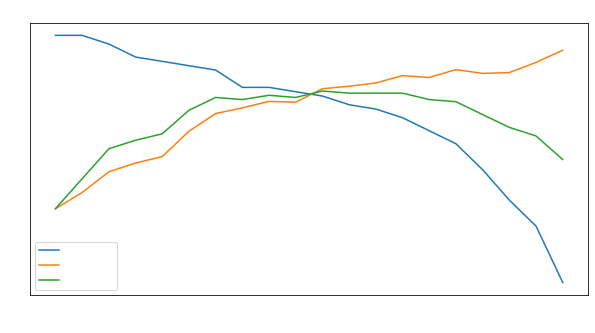

In [37]:
# plotando a curva da Precisão, Sensibilidade e Acurácia 
precisions, recalls, accuracy = precision_recall_accuracy_curve(predict, y)
plot_precision_recall_accuracy_curve(precisions, recalls, accuracy)

In [44]:
# analisando as melhores métricas encontradas para o modelo
best_metrics(threshold = 0.50, predict = predict, y = y)

Matriz de Confusão:
 [[69 14]
 [12 65]]
Acurácia: 0.8375
Precisão 0.8227848101265823
Sensibilidade: 0.8441558441558441
F1_Score: 0.8333333333333334


In [ ]:
# plotando o histórico de treinamento
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model-accuracy')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model-loss')

In [ ]:
# visualizando a arquitetura do modelo
model.summary()